<a href="https://colab.research.google.com/github/dani222222/Ecualizador-en-cascada-de-octava/blob/main/Aplicacion_Sin_audios_GEQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

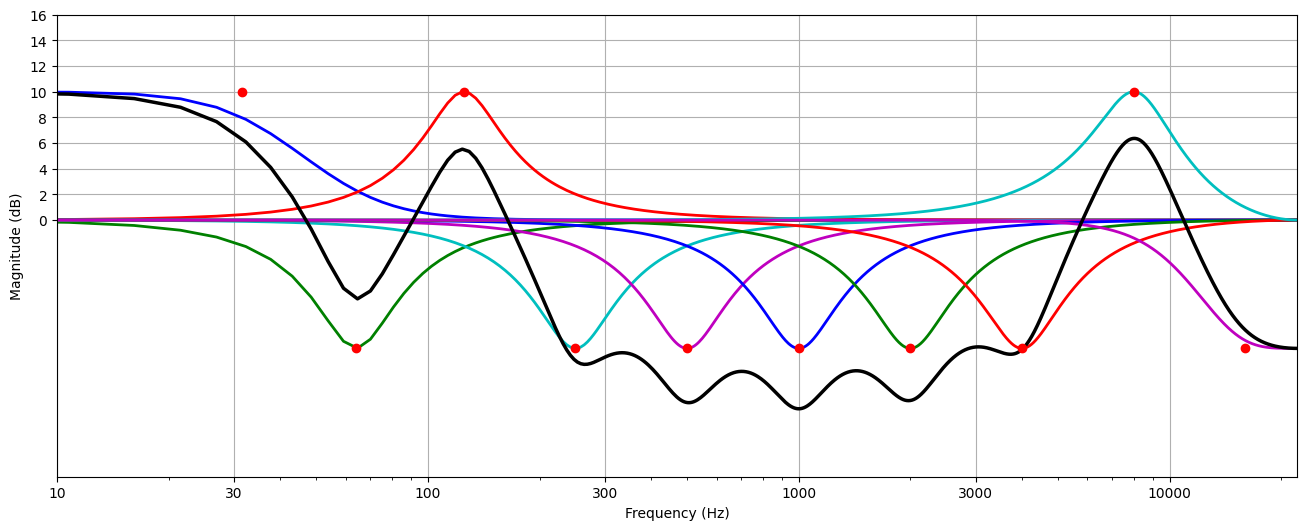

[ 15.62265982  -8.2141477    8.65863775 -13.92637805 -15.75948444
 -16.35616717 -15.59749731 -14.05070448   7.75382946 -10.4827432 ]


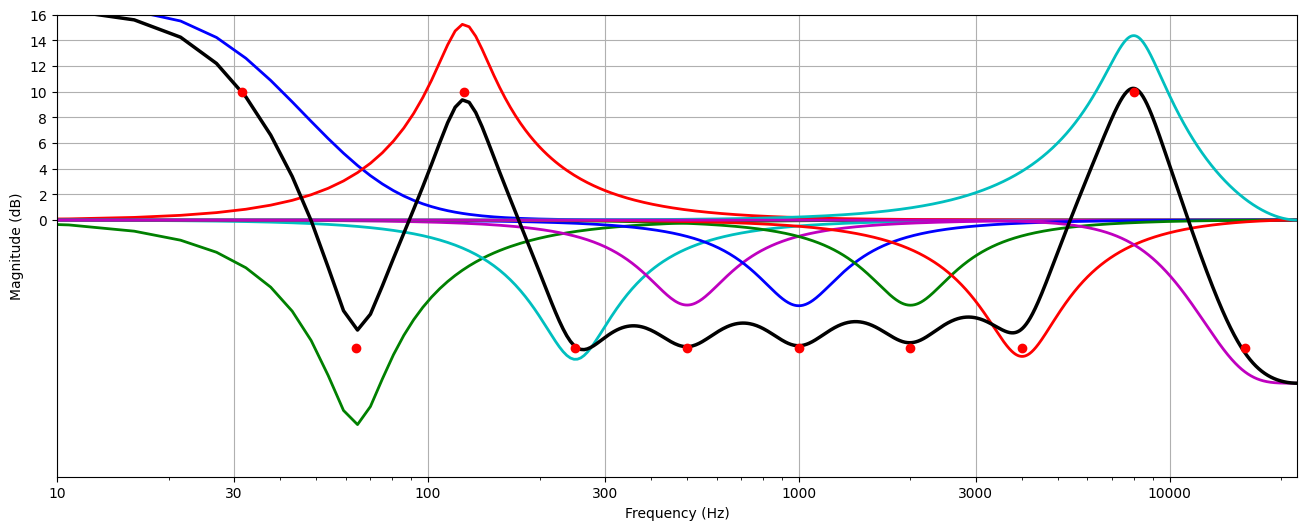

[ 13.74355598 -10.41930964   6.06641265 -17.03846526 -19.46980457
 -20.22380841 -18.84889193 -16.4877196    6.00771    -11.67406369]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Parameters
fs = 44.1e3  # Sample rate
fc = np.array([31.5, 64, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])  # ISO center freqs.
wg = 2 * np.pi * fc / fs  # Command gain frequencies in radians
wc = 2 * np.pi * fc / fs  # Center frequencies in radians
wc[0] = 2 * np.pi * 46 / fs  # Modified crossover frequency for the lowest band
wc[9] = 2 * np.pi * 11360 / fs  # Modified crossover freq. for the highest band
bw = 1 * (np.sqrt(2) - 1 / np.sqrt(2)) * wc  # Bandwidth (constant Q) in radians

# Command gains
Gdb = [10, -10, 10, -10, -10, -10, -10, -10, 10, -10]  # Lista de decibeles para cada banda
G = 10 ** (np.array(Gdb) / 20)  # Convertir a factores de ganancia lineal

def freqz(num, den, worN, fs):
    """
    Filtro en frecuencia utilizando la transformada de Fourier.

    Devuelve la respuesta en frecuencia para un filtro digital `b` y `a`
    definido por coeficientes.

    Parámetros:
        b : array_like
            Coeficientes del numerador del filtro.
        a : array_like
            Coeficientes del denominador del filtro.
        worN : {None, int, array_like}, opcional
            Frecuencias en las que calcular la respuesta en frecuencia.
            Si es un entero, se utiliza como número de puntos de frecuencia.
            Si es una matriz, estas son las frecuencias.
            Si es None, se calcula automáticamente.
        fs : float, opcional
            Frecuencia de muestreo. Se utiliza para calcular las frecuencias
            si `worN` es un entero.

    Devuelve:
        w : array
            Frecuencias (en radianes / unidad de tiempo) en las que se calculó la respuesta en frecuencia.
        h : array
            Respuesta en frecuencia.
    """
    Frecuencias, H = signal.freqz(num, den, worN=worN, fs=fs)
    Magnitud = abs(H)
    return Frecuencias, Magnitud

# Trivial Cascade Graphic EQ Design
def shelf2low(G, wc):
    # Filter coefficients
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(1 / G) * Omega**2 + np.sqrt(2) * Omega * G**(-1/4) + 1
    a1 = 2 * (np.sqrt(1 / G) * Omega**2 - 1)
    a2 = np.sqrt(1 / G) * Omega**2 - np.sqrt(2) * Omega * G**(-1/4) + 1
    b0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    b1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    b2 = np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1

    # Transfer function
    den = [a0, a1, a2]
    num = [b0, b1, b2]
    return num, den


def peaknotch(G, wc, B):
    # Transfer function coefficients
    a0 = np.sqrt(G) + np.tan(B / 2)
    b0 = np.sqrt(G) + G * np.tan(B / 2)
    b1 = -2 * np.sqrt(G) * np.cos(wc)
    b2 = np.sqrt(G) - G * np.tan(B / 2)
    a1 = -2 * np.sqrt(G) * np.cos(wc)
    a2 = np.sqrt(G) - np.tan(B / 2)

    # Transfer function
    num = [b0, b1, b2]
    den = [a0, a1, a2]
    return num, den


def shelf2high(G, wc):
    # Filter coefficients
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    a1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    a2 = (np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1)
    b0 = np.sqrt(G) * (np.sqrt(G) + np.sqrt(2) * Omega * G**(1/4) + Omega**2)
    b1 = np.sqrt(G) * (2 * (-np.sqrt(G) + Omega**2))
    b2 = np.sqrt(G) * (np.sqrt(G) - np.sqrt(2) * Omega * G**(1/4) + Omega**2)

    # Transfer function
    den = [a0, a1, a2]
    num = [b0, b1, b2]
    return num, den


num1, den1 = shelf2low(G[0], wc[0])  # Low shelving filter
num2, den2 = peaknotch(G[1], wc[1], bw[1])  # Peak filter
num3, den3 = peaknotch(G[2], wc[2], bw[2])  # Peak filter
num4, den4 = peaknotch(G[3], wc[3], bw[3])  # Peak filter
num5, den5 = peaknotch(G[4], wc[4], bw[4])  # Peak filter
num6, den6 = peaknotch(G[5], wc[5], bw[5])  # Peak filter
num7, den7 = peaknotch(G[6], wc[6], bw[6])  # Peak filter
num8, den8 = peaknotch(G[7], wc[7], bw[7])  # Peak filter
num9, den9 = peaknotch(G[8], wc[8], bw[8])  # Peak filter
num10, den10 = shelf2high(G[9], wc[9])  # High shelving filter

# Calculate frequency responses
Nfreq = 4096  # Number of frequency points
w = np.logspace(np.log10(0.2), np.log10(22050), Nfreq)  # Log frequency points
w1, H1 = freqz(num1, den1, worN=Nfreq, fs=fs)
w2, H2 = freqz(num2, den2, worN=Nfreq, fs=fs)
w3, H3 = freqz(num3, den3, worN=Nfreq, fs=fs)
w4, H4 = freqz(num4, den4, worN=Nfreq, fs=fs)
w5, H5 = freqz(num5, den5, worN=Nfreq, fs=fs)
w6, H6 = freqz(num6, den6, worN=Nfreq, fs=fs)
w7, H7 = freqz(num7, den7, worN=Nfreq, fs=fs)
w8, H8 = freqz(num8, den8, worN=Nfreq, fs=fs)
w9, H9 = freqz(num9, den9, worN=Nfreq, fs=fs)
w10, H10 = freqz(num10, den10, worN=Nfreq, fs=fs)
Htot = H1 * H2 * H3 * H4 * H5 * H6 * H7 * H8 * H9 * H10  # Overall freq. response

# Optimized Cascade Graphic EQ Design
def compute_leak_factors(G, wg, wc, bw):
    N = len(wc)  # The number of filters
    leak = np.zeros((N, N))  # Initialize interaction matrix
    Gdb = 20 * np.log10(G)  # Convert linear gain factor to dB

    # Estimate leak factors of the first filter (second order low shelf filter)
    num1, den1 = shelf2low(G, wc[0])  # Low shelf filter
    H = np.abs(np.polyval(num1, np.exp(1j * wg)) / np.polyval(den1, np.exp(1j * wg)))  # Frequency response at center frequencies
    Gain = 20 * np.log10(H) / Gdb  # Normalized interference (Re 1 dB)
    leak[0, :] = np.abs(Gain)  # First row of interaction matrix

    # Estimate leak factors of the last filter (second order high shelf filter)
    numN, denN = shelf2high(G, wc[-1])  # High shelf filter
    H = np.abs(np.polyval(numN, np.exp(1j * wg)) / np.polyval(denN, np.exp(1j * wg)))  # Frequency response at center frequencies
    Gain = 20 * np.log10(H) / Gdb  # Normalized interference (Re 1 dB)
    leak[-1, :] = np.abs(Gain)  # Last row of interaction matrix

    # Estimate leak factors of peak/notch filters
    for k in range(1, N - 1):  # Band filters
        num, den = peaknotch(G, wc[k], bw[k])  # Design band filter
        H = np.abs(np.polyval(num, np.exp(1j * wg)) / np.polyval(den, np.exp(1j * wg)))  # Evaluate frequency response
        Gain = 20 * np.log10(H) / Gdb  # Normalized interference (Re 1 dB)
        leak[k, :] = np.abs(Gain)  # Store gain

    return leak


leak = compute_leak_factors(3.2, wg, wc, bw)  # Estimate leakage b/w bands
Goptdb = np.linalg.inv(leak) @ Gdb  # Solve optimal dB gains based on leakage
Gopt = 10 ** (Goptdb / 20)  # Convert to linear gain factors

# Calculate optimized filters
numopt1, denopt1 = shelf2low(Gopt[0], wc[0])  # Low shelving filter
numopt2, denopt2 = peaknotch(Gopt[1], wc[1], bw[1])
numopt3, denopt3 = peaknotch(Gopt[2], wc[2], bw[2])
numopt4, denopt4 = peaknotch(Gopt[3], wc[3], bw[3])
numopt5, denopt5 = peaknotch(Gopt[4], wc[4], bw[4])
numopt6, denopt6 = peaknotch(Gopt[5], wc[5], bw[5])
numopt7, denopt7 = peaknotch(Gopt[6], wc[6], bw[6])
numopt8, denopt8 = peaknotch(Gopt[7], wc[7], bw[7])
numopt9, denopt9 = peaknotch(Gopt[8], wc[8], bw[8])
numopt10, denopt10 = shelf2high(Gopt[9], wc[9])  # Low shelving filter

# Frequency responses
w1o, Hopt1 = freqz(numopt1, denopt1, worN=Nfreq, fs=fs)  # Frecuencia y magnitud de la respuesta
w2o, Hopt2 = freqz(numopt2, denopt2, worN=Nfreq, fs=fs)
w3o, Hopt3 = freqz(numopt3, denopt3, worN=Nfreq, fs=fs)
w4o, Hopt4 = freqz(numopt4, denopt4, worN=Nfreq, fs=fs)
w5o, Hopt5 = freqz(numopt5, denopt5, worN=Nfreq, fs=fs)
w6o, Hopt6 = freqz(numopt6, denopt6, worN=Nfreq, fs=fs)
w7o, Hopt7 = freqz(numopt7, denopt7, worN=Nfreq, fs=fs)
w8o, Hopt8 = freqz(numopt8, denopt8, worN=Nfreq, fs=fs)
w9o, Hopt9 = freqz(numopt9, denopt9, worN=Nfreq, fs=fs)
w10o, Hopt10 = freqz(numopt10, denopt10, worN=Nfreq, fs=fs)
# Overall frequency response:
Hopt = Hopt1 * Hopt2 * Hopt3 * Hopt4 * Hopt5 * Hopt6 * Hopt7 * Hopt8 * Hopt9 * Hopt10

# Figures

# Definir el tamaño deseado de la figura
fig_size = (16, 6)  # Ancho x Alto
linewidth = 2
# Crear la primera figura
plt.figure(1, figsize=fig_size)
plt.semilogx(w1, 20 * np.log10(H1), 'b', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w2, 20 * np.log10(H2), 'g', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w3, 20 * np.log10(H3), 'r', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w4, 20 * np.log10(H4), 'c', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w5, 20 * np.log10(H5), 'm', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w6, 20 * np.log10(H6), 'b', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w7, 20 * np.log10(H7), 'g', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w8, 20 * np.log10(H8), 'r', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w9, 20 * np.log10(H9), 'c', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w10, 20 * np.log10(H10), 'm', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w1, 20 * np.log10(Htot), 'k', linewidth=2.5) # Total response
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.plot(fc, Gdb, 'ro', linewidth=2)  # Command gains
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.axis([10, 22050, min(-1, min(Gdb) - 10), max(0, max(Gdb) + 6)])
plt.grid(True)
plt.show()

# Compute gain error at center frequencies:
error_basic = Gdb - 20 * np.log10(Htot[np.array([893, 1015, 1136, 1258, 1380, 1503, 1625, 1747, 1870, 1991])])
print (error_basic)

# Crear la segunda figura
plt.figure(2, figsize=fig_size)
plt.semilogx(w1o, 20 * np.log10(Hopt1), 'b', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w2o, 20 * np.log10(Hopt2), 'g', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w3o, 20 * np.log10(Hopt3), 'r', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w4o, 20 * np.log10(Hopt4), 'c', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w5o, 20 * np.log10(Hopt5), 'm', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w6o, 20 * np.log10(Hopt6), 'b', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w7o, 20 * np.log10(Hopt7), 'g', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w8o, 20 * np.log10(Hopt8), 'r', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w9o, 20 * np.log10(Hopt9), 'c', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w10o, 20 * np.log10(Hopt10), 'm', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w1o, 20 * np.log10(Hopt), 'k', linewidth=2.5)  # Total response
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.plot(fc, Gdb, 'ro', linewidth=2)  # Command gains
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.axis([10, 22050, min(-1, min(Gdb) - 10), max(0, max(Gdb) + 6)])
plt.grid(True)
plt.show()

# Compute gain error at center frequencies after optimization:
error_opt = Gdb - 20 * np.log10(Hopt[np.array([893, 1015, 1136, 1258, 1380, 1503, 1625, 1747, 1870, 1991])])
print (error_opt)

Mounted at /content/drive


<ipython-input-6-2e68c5994561>:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio = wavfile.read(ruta_audio)
<ipython-input-6-2e68c5994561>:106: RuntimeWarning: invalid value encountered in log10
  spectrograms_db = 10 * np.log10(spectrograms + np.finfo(float).eps)


Dimensiones de frequencies: (513,)
Dimensiones de magnitudes: (5166, 513)


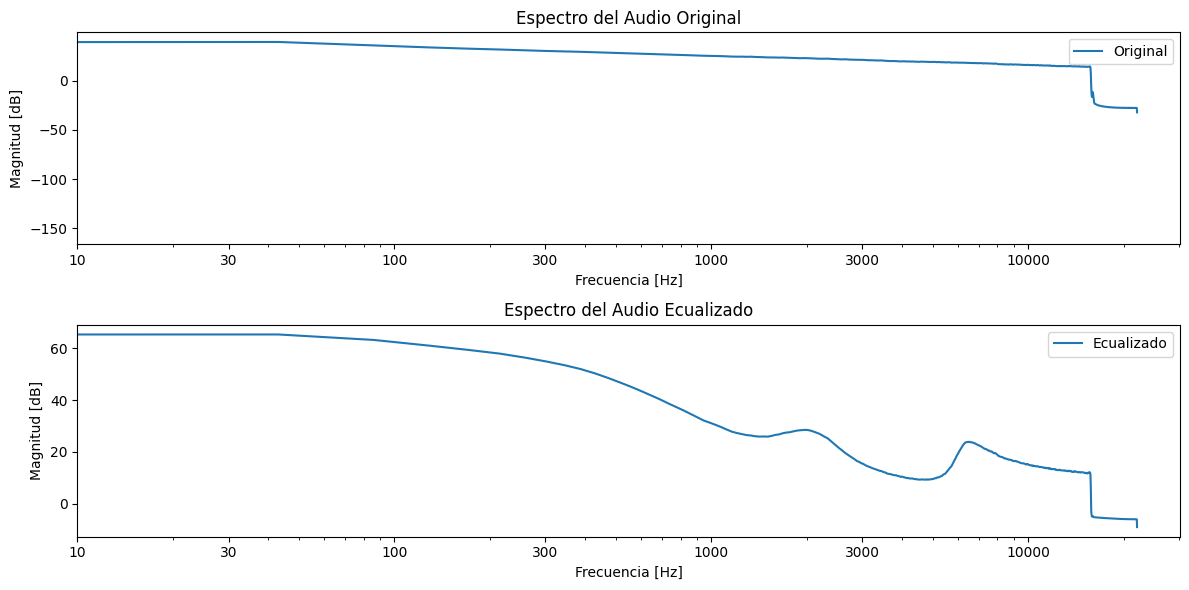

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio

from google.colab import drive
drive.mount('/content/drive')

# Cargar el archivo de audio
ruta_audio = '/content/drive/My Drive/Archivos_prueba/Sonido de Ruido Rosa 1min.wav'
fs, audio = wavfile.read(ruta_audio)

# Asegurarse de que el audio es mono
if len(audio.shape) > 1:
    audio = audio[:, 0]

# Definir parámetros del ecualizador (Ejemplos)
#fc = np.array([31.5, 64, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])  # ISO center freqs.
#wg = 2 * np.pi * fc / fs  # Command gain frequencies in radians
#wc = 2 * np.pi * fc / fs  # Center frequencies in radians
#wc[0] = 2 * np.pi * 46 / fs  # Modified crossover frequency for the lowest band
#wc[9] = 2 * np.pi * 11360 / fs  # Modified crossover freq. for the highest band
#Gopt = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # Ganancia para cada banda (debes ajustarla)
wc = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Frecuencias de corte normalizadas (debes ajustarlas)
#bw = 1 * (np.sqrt(2) - 1 / np.sqrt(2)) * wc  # Bandwidth (constant Q) in radians
bw = [0.3] * 9  # Ancho de banda para filtros peak/notch (debes ajustarlo)
segment_size = 1024  # Tamaño del segmento
overlap = 512  # Solapamiento entre segmentos

# Funciones para el diseño de los filtros
def shelf2low(G, wc):
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(1 / G) * Omega**2 + np.sqrt(2) * Omega * G**(-1/4) + 1
    a1 = 2 * (np.sqrt(1 / G) * Omega**2 - 1)
    a2 = np.sqrt(1 / G) * Omega**2 - np.sqrt(2) * Omega * G**(-1/4) + 1
    b0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    b1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    b2 = np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1
    return [b0, b1, b2], [a0, a1, a2]

def peaknotch(G, wc, B):
    a0 = np.sqrt(G) + np.tan(B / 2)
    b0 = np.sqrt(G) + G * np.tan(B / 2)
    b1 = -2 * np.sqrt(G) * np.cos(wc)
    b2 = np.sqrt(G) - G * np.tan(B / 2)
    a1 = -2 * np.sqrt(G) * np.cos(wc)
    a2 = np.sqrt(G) - np.tan(B / 2)
    return [b0, b1, b2], [a0, a1, a2]

def shelf2high(G, wc):
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    a1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    a2 = (np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1)
    b0 = np.sqrt(G) * (np.sqrt(G) + np.sqrt(2) * Omega * G**(1/4) + Omega**2)
    b1 = np.sqrt(G) * (2 * (-np.sqrt(G) + Omega**2))
    b2 = np.sqrt(G) * (np.sqrt(G) - np.sqrt(2) * Omega * G**(1/4) + Omega**2)
    return [b0, b1, b2], [a0, a1, a2]

# Calcular los coeficientes para cada banda
num1, den1 = shelf2low(Gopt[0], wc[0])  # Low shelving filter
num2, den2 = peaknotch(Gopt[1], wc[1], bw[1])
num3, den3 = peaknotch(Gopt[2], wc[2], bw[2])
num4, den4 = peaknotch(Gopt[3], wc[3], bw[3])
num5, den5 = peaknotch(Gopt[4], wc[4], bw[4])
num6, den6 = peaknotch(Gopt[5], wc[5], bw[5])
num7, den7 = peaknotch(Gopt[6], wc[6], bw[6])
num8, den8 = peaknotch(Gopt[7], wc[7], bw[7])
num9, den9 = peaknotch(Gopt[8], wc[8], bw[8])
num10, den10 = shelf2high(Gopt[9], wc[9])  # High shelving filter

# Combina los coeficientes de todos los filtros
num_combined = np.convolve(num1, np.convolve(num2, np.convolve(num3, np.convolve(num4, np.convolve(num5, np.convolve(num6, np.convolve(num7, np.convolve(num8, np.convolve(num9, num10)))))))))
den_combined = np.convolve(den1, np.convolve(den2, np.convolve(den3, np.convolve(den4, np.convolve(den5, np.convolve(den6, np.convolve(den7, np.convolve(den8, np.convolve(den9, den10)))))))))

# Aplicar la respuesta en frecuencia combinada al audio
audio_ecualizado = signal.lfilter(num_combined, den_combined, audio)

# Calcular la cantidad total de segmentos
num_segments = (len(audio) - overlap) // (segment_size - overlap)

# Inicializar matrices para almacenar los espectros de potencia
spectrograms = []

for i in range(num_segments):
    # Calcular el inicio y fin del segmento actual
    start = i * (segment_size - overlap)
    end = start + segment_size

    # Aplicar ventana de Hamming al segmento
    segment = audio[start:end].astype(np.float64)
    hamming_window = np.hamming(segment_size).astype(np.float64)
    segment *= hamming_window

    # Calcular el espectro de potencia del segmento
    frequencies, Pxx = signal.periodogram(segment, fs=fs)

    # Almacenar el espectro de potencia en dB
    spectrograms.append(10 * np.log10(Pxx + np.finfo(float).eps))

# Convertir la lista de espectrogramas en un arreglo numpy
spectrograms = np.array(spectrograms)

# Convertir la densidad espectral de potencia a decibeles
spectrograms_db = 10 * np.log10(spectrograms + np.finfo(float).eps)

# Verificar las dimensiones de los arreglos
print("Dimensiones de frequencies:", frequencies.shape)
print("Dimensiones de magnitudes:", spectrograms_db.shape)

# Graficar el espectro del audio original y ecualizado
plt.figure(figsize=(12, 6))

# Gráficos escalados logarítmicamente
plt.subplot(2, 1, 1)
plt.semilogx(frequencies, np.mean(spectrograms, axis=0).T, label='Original')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del Audio Original')
plt.legend()

# Calcular el espectro del audio ecualizado con una ventana de tamaño fijo
frequencies_ec, magnitudes_ec = signal.welch(audio_ecualizado, fs=fs, window='hamming', nperseg=1024)

# Graficar el espectro del audio ecualizado
plt.subplot(2, 1, 2)
plt.semilogx(frequencies_ec, 10 * np.log10(magnitudes_ec + np.finfo(float).eps), label='Ecualizado')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del Audio Ecualizado')
plt.legend()

plt.tight_layout()
plt.show()

# Guardar el audio ecualizado en un archivo WAV
ruta_audio_ecualizado = '/content/drive/My Drive/Archivos_prueba/Sonido_Ecualizado.wav'
wavfile.write(ruta_audio_ecualizado, fs, audio_ecualizado.astype(np.int16))

# Reproducir el audio original y ecualizado
#print("Audio Original:")
#display(Audio(audio, rate=fs))

#print("Audio Ecualizado:")
#display(Audio(audio_ecualizado, rate=fs))


<ipython-input-7-3ff30eed084d>:97: RuntimeWarning: invalid value encountered in log10
  spectrograms_db = 10 * np.log10(spectrograms + np.finfo(float).eps)


Dimensiones de frequencies: (513,)
Dimensiones de magnitudes: (22397, 513)


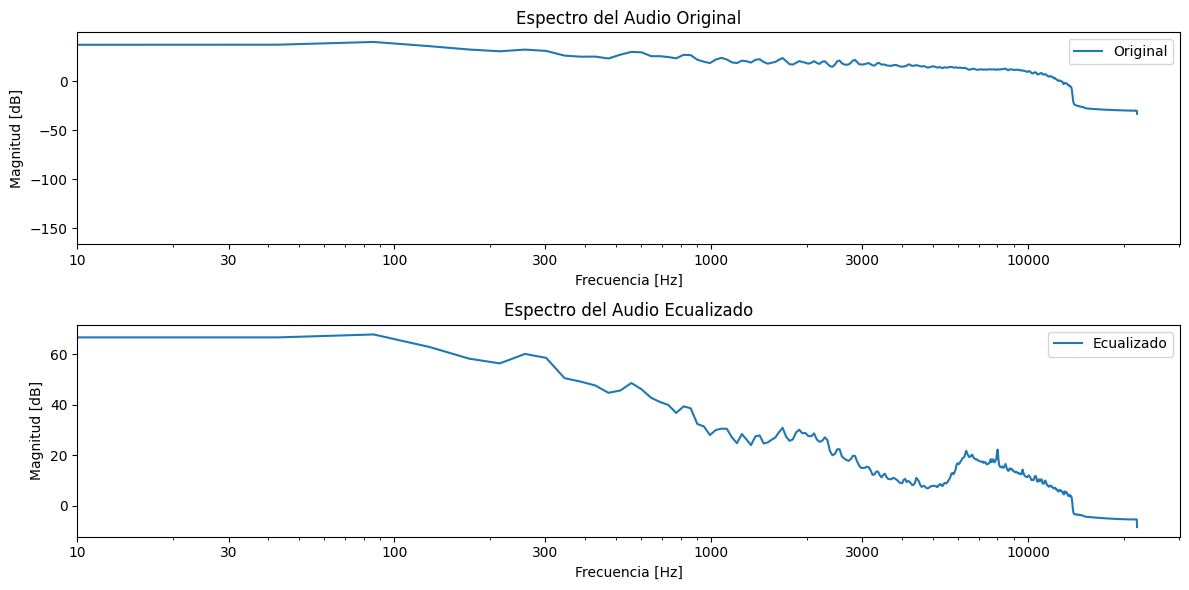

In [7]:

# Cargar el archivo de audio
ruta_audio2 = '/content/drive/My Drive/Archivos_prueba/SONORA-DINAMITA-TALENTO-DE-TELEVISION-canta-NANDO-MALO1.wav'
fs, audio2 = wavfile.read(ruta_audio2)

# Asegurarse de que el audio es mono
if len(audio2.shape) > 1:
    audio2 = audio2[:, 0]

# Definir parámetros del ecualizador (Ejemplos)
#fc = np.array([31.5, 64, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])  # ISO center freqs.
#wg = 2 * np.pi * fc / fs  # Command gain frequencies in radians
#wc = 2 * np.pi * fc / fs  # Center frequencies in radians
#wc[0] = 2 * np.pi * 46 / fs  # Modified crossover frequency for the lowest band
#wc[9] = 2 * np.pi * 11360 / fs  # Modified crossover freq. for the highest band
#bw = 1 * (np.sqrt(2) - 1 / np.sqrt(2)) * wc  # Bandwidth (constant Q) in radians
#Gopt = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # Ganancia para cada banda (debes ajustarla)
wc = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Frecuencias de corte normalizadas (debes ajustarlas)
bw = [0.3] * 9  # Ancho de banda para filtros peak/notch (debes ajustarlo)
segment_size = 1024  # Tamaño del segmento
overlap = 512  # Solapamiento entre segmentos

# Funciones para el diseño de los filtros
def shelf2low(G, wc):
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(1 / G) * Omega**2 + np.sqrt(2) * Omega * G**(-1/4) + 1
    a1 = 2 * (np.sqrt(1 / G) * Omega**2 - 1)
    a2 = np.sqrt(1 / G) * Omega**2 - np.sqrt(2) * Omega * G**(-1/4) + 1
    b0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    b1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    b2 = np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1
    return [b0, b1, b2], [a0, a1, a2]

def peaknotch(G, wc, B):
    a0 = np.sqrt(G) + np.tan(B / 2)
    b0 = np.sqrt(G) + G * np.tan(B / 2)
    b1 = -2 * np.sqrt(G) * np.cos(wc)
    b2 = np.sqrt(G) - G * np.tan(B / 2)
    a1 = -2 * np.sqrt(G) * np.cos(wc)
    a2 = np.sqrt(G) - np.tan(B / 2)
    return [b0, b1, b2], [a0, a1, a2]

def shelf2high(G, wc):
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    a1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    a2 = (np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1)
    b0 = np.sqrt(G) * (np.sqrt(G) + np.sqrt(2) * Omega * G**(1/4) + Omega**2)
    b1 = np.sqrt(G) * (2 * (-np.sqrt(G) + Omega**2))
    b2 = np.sqrt(G) * (np.sqrt(G) - np.sqrt(2) * Omega * G**(1/4) + Omega**2)
    return [b0, b1, b2], [a0, a1, a2]

# Calcular los coeficientes para cada banda
num1, den1 = shelf2low(Gopt[0], wc[0])  # Low shelving filter
num2, den2 = peaknotch(Gopt[1], wc[1], bw[1])
num3, den3 = peaknotch(Gopt[2], wc[2], bw[2])
num4, den4 = peaknotch(Gopt[3], wc[3], bw[3])
num5, den5 = peaknotch(Gopt[4], wc[4], bw[4])
num6, den6 = peaknotch(Gopt[5], wc[5], bw[5])
num7, den7 = peaknotch(Gopt[6], wc[6], bw[6])
num8, den8 = peaknotch(Gopt[7], wc[7], bw[7])
num9, den9 = peaknotch(Gopt[8], wc[8], bw[8])
num10, den10 = shelf2high(Gopt[9], wc[9])  # High shelving filter

# Combina los coeficientes de todos los filtros
num_combined = np.convolve(num1, np.convolve(num2, np.convolve(num3, np.convolve(num4, np.convolve(num5, np.convolve(num6, np.convolve(num7, np.convolve(num8, np.convolve(num9, num10)))))))))
den_combined = np.convolve(den1, np.convolve(den2, np.convolve(den3, np.convolve(den4, np.convolve(den5, np.convolve(den6, np.convolve(den7, np.convolve(den8, np.convolve(den9, den10)))))))))

# Aplicar la respuesta en frecuencia combinada al audio
audio2_ecualizado = signal.lfilter(num_combined, den_combined, audio2)

# Calcular la cantidad total de segmentos
num_segments = (len(audio2) - overlap) // (segment_size - overlap)

# Inicializar matrices para almacenar los espectros de potencia
spectrograms = []

for i in range(num_segments):
    # Calcular el inicio y fin del segmento actual
    start = i * (segment_size - overlap)
    end = start + segment_size

    # Aplicar ventana de Hamming al segmento
    segment = audio2[start:end].astype(np.float64)
    hamming_window = np.hamming(segment_size).astype(np.float64)
    segment *= hamming_window

    # Calcular el espectro de potencia del segmento
    frequencies, Pxx = signal.periodogram(segment, fs=fs)

    # Almacenar el espectro de potencia en dB
    spectrograms.append(10 * np.log10(Pxx + np.finfo(float).eps))

# Convertir la lista de espectrogramas en un arreglo numpy
spectrograms = np.array(spectrograms)

# Convertir la densidad espectral de potencia a decibeles
spectrograms_db = 10 * np.log10(spectrograms + np.finfo(float).eps)

# Verificar las dimensiones de los arreglos
print("Dimensiones de frequencies:", frequencies.shape)
print("Dimensiones de magnitudes:", spectrograms_db.shape)

# Graficar el espectro del audio original y ecualizado
plt.figure(figsize=(12, 6))

# Gráficos escalados logarítmicamente
plt.subplot(2, 1, 1)
plt.semilogx(frequencies, np.mean(spectrograms, axis=0).T, label='Original')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del Audio Original')
plt.legend()

# Calcular el espectro del audio ecualizado con una ventana de tamaño fijo
frequencies_ec, magnitudes_ec = signal.welch(audio2_ecualizado, fs=fs, window='hamming', nperseg=1024)

# Graficar el espectro del audio ecualizado
plt.subplot(2, 1, 2)
plt.semilogx(frequencies_ec, 10 * np.log10(magnitudes_ec + np.finfo(float).eps), label='Ecualizado')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del Audio Ecualizado')
plt.legend()

plt.tight_layout()
plt.show()

# Guardar el audio ecualizado en un archivo WAV
#ruta_audio2_ecualizado = '/content/drive/My Drive/Archivos_prueba/Cancion_Ecualizado2.wav'
#wavfile.write(ruta_audio2_ecualizado, fs, audio2_ecualizado.astype(np.int16))

# Reproducir el audio original y ecualizado
#print("Audio Original:")
#display(Audio(audio2, rate=fs))

#print("Cancion Ecualizada:")
#display(Audio(audio2_ecualizado, rate=fs))
